In [1]:
import pandas as pd
import numpy as np
import librosa

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

df = pd.read_csv('Path_DF.csv')
valve_train = df[(df.Dataset == 'train') & (df.Machine_Type == 'valve')]

valve_train.head()

,Path,Machine_Type,Dataset,Status,Machine_ID,Sample_ID,nb_echantillon,freq_echantillonnage,audio
7388,Data/valve/train/normal_id_04_00000895.wav,valve,train,normal,4,895,160000,16000,[-0.0067749 -0.00421143 -0.00149536 ... -0.01...
7389,Data/valve/train/normal_id_00_00000692.wav,valve,train,normal,0,692,160000,16000,[-1.6845703e-02 -8.6669922e-03 -9.1552734e-05 ...
7390,Data/valve/train/normal_id_06_00000093.wav,valve,train,normal,6,93,160000,16000,[-0.00506592 -0.00900269 -0.00445557 ... 0.00...
7391,Data/valve/train/normal_id_00_00000686.wav,valve,train,normal,0,686,160000,16000,[ 0.00064087 0.00460815 0.00891113 ... 0.00...
7392,Data/valve/train/normal_id_06_00000087.wav,valve,train,normal,6,87,160000,16000,[-0.01055908 -0.01242065 -0.01312256 ... -0.02...


## Cette fonction permet de faire une sélection de features MFEC sur un fichier audio 

In [2]:
def file_load_stream(wav_name, mono=False):
    frameSize = librosa.get_samplerate(wav_name)
    hoplength = frameSize // 2
    stream = librosa.stream(wav_name, block_length=1, frame_length=frameSize, hop_length=hoplength, mono=mono)
    return stream

In [3]:
file_load_stream(df.iloc[0,0])

<generator object stream at 0x7fc80c27c740>

## On va créer une fonction qui transforme le fichier MFEC en des vecteurs numpy


In [4]:
import sys

def file_to_vector_array_stream_test_data(file_name, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1):
    """
    convert file_name to a vector array.
    file_name : str
        target .wav file
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames
    
    # 02 generate melspectrogram using librosa
    stream = file_load_stream(file_name)
    sr = librosa.get_samplerate(file_name)
    liste = []
    for n, y in enumerate(stream):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)

        # 03 convert melspectrogram

        log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

        # 04 calculate total vector size
        vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1  
        
        # 05 skip too short clips
        if vector_array_size < 1:
            return np.empty((0, dims))

        # 06 generate feature vectors by concatenating multiframes
        vector_array = np.zeros((vector_array_size, dims))

        for t in range(frames):
            vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

        liste.append(vector_array)

    liste = np.asarray(liste)
    liste = liste.reshape(liste.shape[0] * liste.shape[1], liste.shape[2])
    return liste

In [5]:
nb_extract = 532

file_to_vector_array_stream_test_data(df.iloc[0,0]).shape

(532, 640)

## A partir d'un Dataframe, on crée un ensemble de données exploitable pour le modèle Dense AE

In [6]:
def dataset_stream(set_files):
    """
    renvoie une dataset sur laquelle entrainer/évaluer le modèle Dense_AE
    set_files est un DataFrame et sa première colonne contient les chemins
    """
    liste = []
    for k in range(len(set_files)):
        for l in file_to_vector_array_stream_test_data(set_files.iloc[k,0]):
            liste.append(l)
    return np.asarray(liste)

from time import time
t0 = time()

valve_train_stream = dataset_stream(valve_train)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 250.964 secondes


In [7]:
valve_train_stream.shape

(1750812, 640)

## On entraine un modèle DenseAE avec la dataset nouvellement créée

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, BatchNormalization, ReLU, Reshape


In [9]:
def model_denseAE(input_shape = (640,)):
    model_dense = Sequential()

    # Première couche Encoder
    model_dense.add(Dense(512, input_shape = input_shape))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Seconde couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Troisième couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Quatrième couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Couche goulot
    model_dense.add(Dense(8))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Première couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Seconde couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Troisième couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Quatrième couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Couche de reconstruction 
    model_dense.add(Dense(640))
    
    return model_dense

model_dense = model_denseAE()

# On compile 
model_dense.compile(optimizer='adam', loss="mse")

In [11]:
import os
cwd = os.getcwd()
filepath = cwd + '/valve_DenseAE'

filepath

'/Users/romeo/Formation DataScientist/projet pynomaly/valve_DenseAE'

In [12]:
from tensorflow.keras import callbacks

# Callback pour arrêter l'entrainement et récupérer le meilleur modèle si la métrique ne diminue plus pendant 10 epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

import os
cwd = os.getcwd()
filepath = cwd

# Callback pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, 
                                       save_weights_only = False, mode = 'min', save_freq = 'epoch')

t0 = time()

# On entraine le modèle sur valve_train. 
model_dense.fit(valve_train_stream, valve_train_stream, batch_size = 512, epochs = 100, callbacks=[checkpoint, early_stopping], validation_split = 0.3)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Epoch 1/100
2394/2394 [==============================] - 340s 139ms/step - loss: 221.6670 - val_loss: 13.6343
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 2/100
2394/2394 [==============================] - 194s 81ms/step - loss: 12.2978 - val_loss: 12.9189
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 3/100
2394/2394 [==============================] - 173s 72ms/step - loss: 11.4951 - val_loss: 12.6637
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 4/100
2394/2394 [==============================] - 177s 74ms/step - loss: 11.1217 - val_loss: 11.9391
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 5/100
2394/2394 [==============================] - 173s 72ms/step - loss: 10.9058 - val_loss: 11.8135
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet

In [114]:
#model_dense_valve = tf.saved_model.load('/Users/romeo/Formation DataScientist/projet pynomaly')

#model_dense_valve

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb96d2d8d60>

### On crée la dataset d'évaluation

In [13]:
valve_test = df[(df.Dataset == 'test') & (df.Machine_Type == 'valve')]

t0 = time()

valve_test_stream = dataset_stream(valve_test)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 51.96 secondes


In [14]:
# Pour déterminer le seuil à partir duquel on peut dire qu'une prise de son est anormale

pred_valve_train = model_dense.predict(valve_train_stream)

In [15]:
def errors(X_true, X_pred, length, nb_extract = 532): 
    """
    calcule les erreurs entre le jeu de départ et les prédictions du modèle
    """
    vect_error = np.mean(np.square(X_true - X_pred), axis=1)
    errors = np.zeros(length)
    for k in range(length):
        errors[k] = np.mean(vect_error[k*nb_extract : (k+1)*nb_extract])
    return errors


In [16]:
error_valve_train = errors(valve_train_stream, pred_valve_train, len(valve_train))

#print(error_valve)
print('Moyenne des erreurs :', np.mean(error_valve_train))
print('Ecart-type des erreurs :', np.std(error_valve_train))

# Donc un seuil un peu plus grand que 11.3 est bien pour trouver les prises de sons anormales détectées par le modèle

Moyenne des erreurs : 10.293044432549216
Ecart-type des erreurs : 1.054840767127492


In [17]:
pred_valve_test = model_dense.predict(valve_test_stream)

error_valve_test = errors(valve_test_stream, pred_valve_test, len(valve_test))


In [19]:
y_true = valve_test['Status'].replace(['normal', 'anomaly'], [0,1])

y_true.value_counts()

1    479
0    400
Name: Status, dtype: int64

In [55]:
seuil = 10.1 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_valve_test[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,228,172
1,78,401


In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.57      0.65       400
           1       0.70      0.84      0.76       479

    accuracy                           0.72       879
   macro avg       0.72      0.70      0.70       879
weighted avg       0.72      0.72      0.71       879



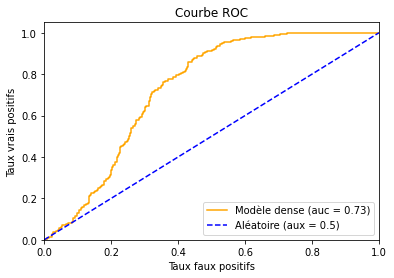

In [57]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true, error_valve_test, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [58]:
auc = roc_auc_score(y_true, y_pred)
p_auc = roc_auc_score(y_true, y_pred, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.703580375782881
pAUC : 0.5249180386515154


## Affinons notre analyse selon le Machine_ID

In [35]:
#valve_train.Machine_ID.value_counts()
valve_train.Machine_ID.unique()

array([4, 0, 6, 2])

### Premier Machine_ID : 0

In [51]:
error_valve_train_0 = error_valve_train[valve_train.Machine_ID == 0]

print('Moyenne des erreurs :', np.mean(error_valve_train_0))
print('Ecart-type des erreurs :', np.std(error_valve_train_0))

seuil = 9.9 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.178390053242872
Ecart-type des erreurs : 1.043146230600033


In [52]:
y_true_0 = y_true[valve_test.Machine_ID == 0]
y_pred_0 = np.where(error_valve_test[valve_test.Machine_ID == 0][:] > seuil, 1, 0)

print(classification_report(y_true_0, y_pred_0))
pd.crosstab(y_true_0, y_pred_0, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.90      0.55      0.68       100
           1       0.72      0.95      0.82       119

    accuracy                           0.77       219
   macro avg       0.81      0.75      0.75       219
weighted avg       0.80      0.77      0.76       219



Classe prédite,0,1
Classe réelle,,
0,55,45
1,6,113


In [53]:
auc = roc_auc_score(y_true_0, y_pred_0)
p_auc = roc_auc_score(y_true_0, y_pred_0, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7497899159663866
pAUC : 0.5292151948498698


### Deuxième Machine_ID : 2 

In [69]:
error_valve_train_2 = error_valve_train[valve_train.Machine_ID == 2]

print('Moyenne des erreurs :', np.mean(error_valve_train_2))
print('Ecart-type des erreurs :', np.std(error_valve_train_2))

seuil = 10.0 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.307433699450133
Ecart-type des erreurs : 1.0451608130990468


In [70]:
y_true_2 = y_true[valve_test.Machine_ID == 2]
y_pred_2 = np.where(error_valve_test[valve_test.Machine_ID == 2][:] > seuil, 1, 0)

print(classification_report(y_true_2, y_pred_2))
pd.crosstab(y_true_2, y_pred_2, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.94      0.47      0.63       100
           1       0.69      0.97      0.81       120

    accuracy                           0.75       220
   macro avg       0.81      0.72      0.72       220
weighted avg       0.80      0.75      0.72       220



Classe prédite,0,1
Classe réelle,,
0,47,53
1,3,117


In [71]:
auc = roc_auc_score(y_true_2, y_pred_2)
p_auc = roc_auc_score(y_true_2, y_pred_2, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7225
pAUC : 0.5220953326713009


### Troisième Machine_ID : 4

In [79]:
error_valve_train_4 = error_valve_train[valve_train.Machine_ID == 4]

print('Moyenne des erreurs :', np.mean(error_valve_train_4))
print('Ecart-type des erreurs :', np.std(error_valve_train_4))

seuil = 10.2 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.322740433319606
Ecart-type des erreurs : 0.9842641561083222


In [80]:
y_true_4 = y_true[valve_test.Machine_ID == 4]
y_pred_4 = np.where(error_valve_test[valve_test.Machine_ID == 4][:] > seuil, 1, 0)

print(classification_report(y_true_4, y_pred_4))
pd.crosstab(y_true_4, y_pred_4, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       100
           1       0.74      0.95      0.83       120

    accuracy                           0.79       220
   macro avg       0.82      0.77      0.78       220
weighted avg       0.82      0.79      0.78       220



Classe prédite,0,1
Classe réelle,,
0,60,40
1,6,114


In [81]:
auc = roc_auc_score(y_true_4, y_pred_4)
p_auc = roc_auc_score(y_true_4, y_pred_4, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7749999999999999
pAUC : 0.5361842105263158


### Quatrième Machine_ID : 6

In [85]:
error_valve_train_6 = error_valve_train[valve_train.Machine_ID == 6]

print('Moyenne des erreurs :', np.mean(error_valve_train_6))
print('Ecart-type des erreurs :', np.std(error_valve_train_6))

seuil = 10.1 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.367800012137605
Ecart-type des erreurs : 1.1298256344127315


In [86]:
y_true_6 = y_true[valve_test.Machine_ID == 6]
y_pred_6 = np.where(error_valve_test[valve_test.Machine_ID == 6][:] > seuil, 1, 0)

print(classification_report(y_true_6, y_pred_6))
pd.crosstab(y_true_6, y_pred_6, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.65      0.50      0.56       100
           1       0.65      0.78      0.71       120

    accuracy                           0.65       220
   macro avg       0.65      0.64      0.64       220
weighted avg       0.65      0.65      0.64       220



Classe prédite,0,1
Classe réelle,,
0,50,50
1,27,93


In [87]:
auc = roc_auc_score(y_true_6, y_pred_6)
p_auc = roc_auc_score(y_true_6, y_pred_6, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.6375
pAUC : 0.5144736842105263
